In [62]:
args = {
    'model_name':'HP-ART',
    'FP':'float32',
    'optimizer': 'Adam', #SGD, RMSprop, Adadelta, Adagrad, Adam, Adamax, Nadam
    'dataset':'~/datasets/HP-ART/',
    'batch_size':None,
    'split_point': 0.8, #80% Training , 20% Validation
    'rnd_seed': 1234,
    'folds':5,
    'epochs_number':5,
    'image_size':64,
    'resume': False
}

clean_args = {
    'rm_na': True,
    'rm_cor': False,
    'reduce': False,
}

In [63]:
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor  # Ensemble methods
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split # Model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR 

from xgboost import XGBRegressor, DMatrix, plot_importance # XGBoost
from lightgbm import LGBMRegressor

In [64]:
# Load data and display info
df_train = pd.read_csv(args['dataset'] + 'train.csv', index_col = 0) 
df_test = pd.read_csv(args['dataset'] + 'test.csv', index_col = 0) 

In [65]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

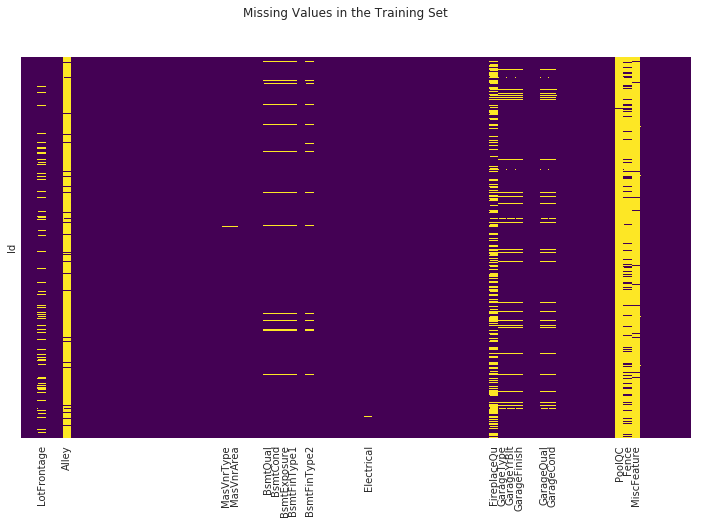

In [66]:
label_nas = []
for col in df_train.columns.tolist():
    if np.sum(df_train[col].isnull() ) != 0:
        label_nas.append(col)
    else:
        label_nas.append("")

plt.figure(figsize=(12,7))
plt.suptitle('Missing Values in the Training Set')
sns.heatmap(df_train.isnull(), yticklabels=False, xticklabels=label_nas ,cbar = False, cmap='viridis')
plt.show()

In [67]:
null_values_per_col = np.sum(df_train.drop(["SalePrice"], axis=1).isnull(), axis=0)
#print("Null values per columns")
#print(null_values_per_col)

max_na = int(df_train.shape[0]/3.0)
cols_to_remove = []

for col in df_train.drop(["SalePrice"],axis=1).columns.tolist():
    if null_values_per_col[col] > max_na: 
        cols_to_remove.append(col)
        df_train.drop(col, axis=1, inplace=True)
        
print("New shape of the training set is: (%d,%d)" %df_train.shape)        
print("The removed columns are: " + str(cols_to_remove))

#for column in cols_to_remove:
#    print(column, "Dropped because it has %d missing values" %null_values_per_col[column])
    
#print("Dropping the same columns from the test set")    
df_test.drop(cols_to_remove, axis=1, inplace=True)

#print("New shape of the test set is: (%d,%d)" %df_test.shape)   

New shape of the training set is: (1460,75)
The removed columns are: ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


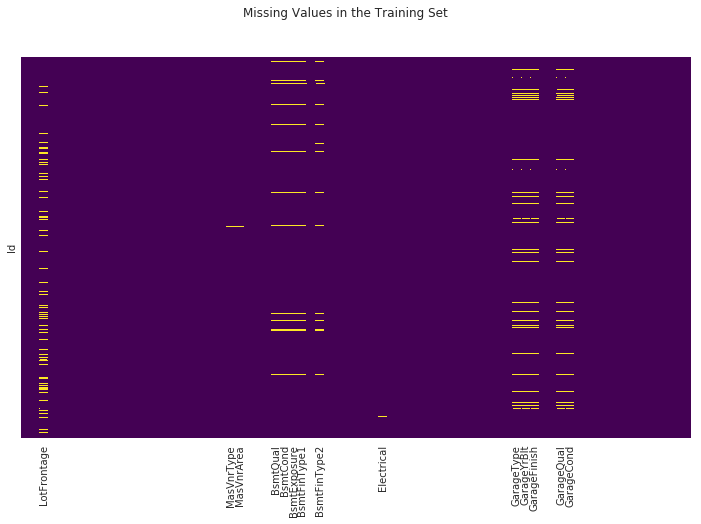

In [68]:
label_nas = []
for col in df_train.columns.tolist():
    if np.sum(df_train[col].isnull() ) != 0:
        label_nas.append(col)
    else:
        label_nas.append("")

plt.figure(figsize=(12,7))
plt.suptitle('Missing Values in the Training Set')
sns.heatmap(df_train.isnull(), yticklabels=False, xticklabels=label_nas ,cbar = False, cmap='viridis')
plt.show()

In [69]:
# reduce some known redundant features
if clean_args['reduce']:
    df_train['TotalSF'] = (df_train['BsmtFinSF1'] + df_train['BsmtFinSF2'] +
                                     df_train['1stFlrSF'] + df_train['2ndFlrSF'])

    df_train['TotalBathrooms'] = (df_train['FullBath'] + (0.5 * df_train['HalfBath']) +
                                   df_train['BsmtFullBath'] + (0.5 * df_train['BsmtHalfBath']))

    df_train['TotalPorchSF'] = (df_train['OpenPorchSF'] + df_train['3SsnPorch'] +
                                  df_train['EnclosedPorch'] + df_train['ScreenPorch'] +
                                  df_train['WoodDeckSF'])


    df_test['TotalSF'] = (df_test['BsmtFinSF1'] + df_test['BsmtFinSF2'] +
                                     df_test['1stFlrSF'] + df_test['2ndFlrSF'])

    df_test['TotalBathrooms'] = (df_test['FullBath'] + (0.5 * df_test['HalfBath']) +
                                   df_test['BsmtFullBath'] + (0.5 * df_test['BsmtHalfBath']))

    df_test['TotalPorchSF'] = (df_test['OpenPorchSF'] + df_test['3SsnPorch'] +
                                  df_test['EnclosedPorch'] + df_test['ScreenPorch'] +
                                  df_test['WoodDeckSF'])
    
    # remove the old ones
    columns_rm = ['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'BsmtFullBath',
                  'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF']
    df_train = df_train.drop(columns_rm, axis=1)
    df_test = df_test.drop(columns_rm, axis=1)

In [70]:
rep_map_1 = {"NA": 0, "Po": 1,
             "Fa": 2, "TA": 3, 
             "Gd": 4, "Ex": 5,}

rep_map_2 = {"NA": 0, "No": 1,
             "Mn": 2, "Av": 3, 
             "Gd": 4,}

rep_map_3 = {"NA": 0, "Unf": 1,
             "LwQ": 2, "Rec": 3, 
             "BLQ": 4, "ALQ": 5,
             "GLQ": 6,}

rep_map_4 = {"NA": 0, "MnWw": 1,
             "GdWo": 2, "MnPrv": 3, 
             "GdPrv": 4,}

scale_list_1 = ["ExterCond", "BsmtCond", "HeatingQC", "KitchenQual", "GarageCond"]
scale_list_2 = ["BsmtFinType1"]
scale_list_3 = ["BsmtFinType2"]
scale_list_4 = ["Fence"]

In [71]:
for s in scale_list_1:
    df_train = df_train.replace({s:rep_map_1,})
    df_test = df_test.replace({s:rep_map_1,})

df_train = df_train.replace({scale_list_2[0]:rep_map_2,
                             scale_list_3[0]:rep_map_3,
                             scale_list_4[0]:rep_map_4,})

df_test = df_test.replace({scale_list_2[0]:rep_map_2,
                             scale_list_3[0]:rep_map_3,
                             scale_list_4[0]:rep_map_4,})

#df_test['GarageQual'] = df_test['GarageQual'].fillna(0)

In [72]:
# correlation matrix
corr_mat = df_train.drop(columns=["SalePrice"]).corr().abs()

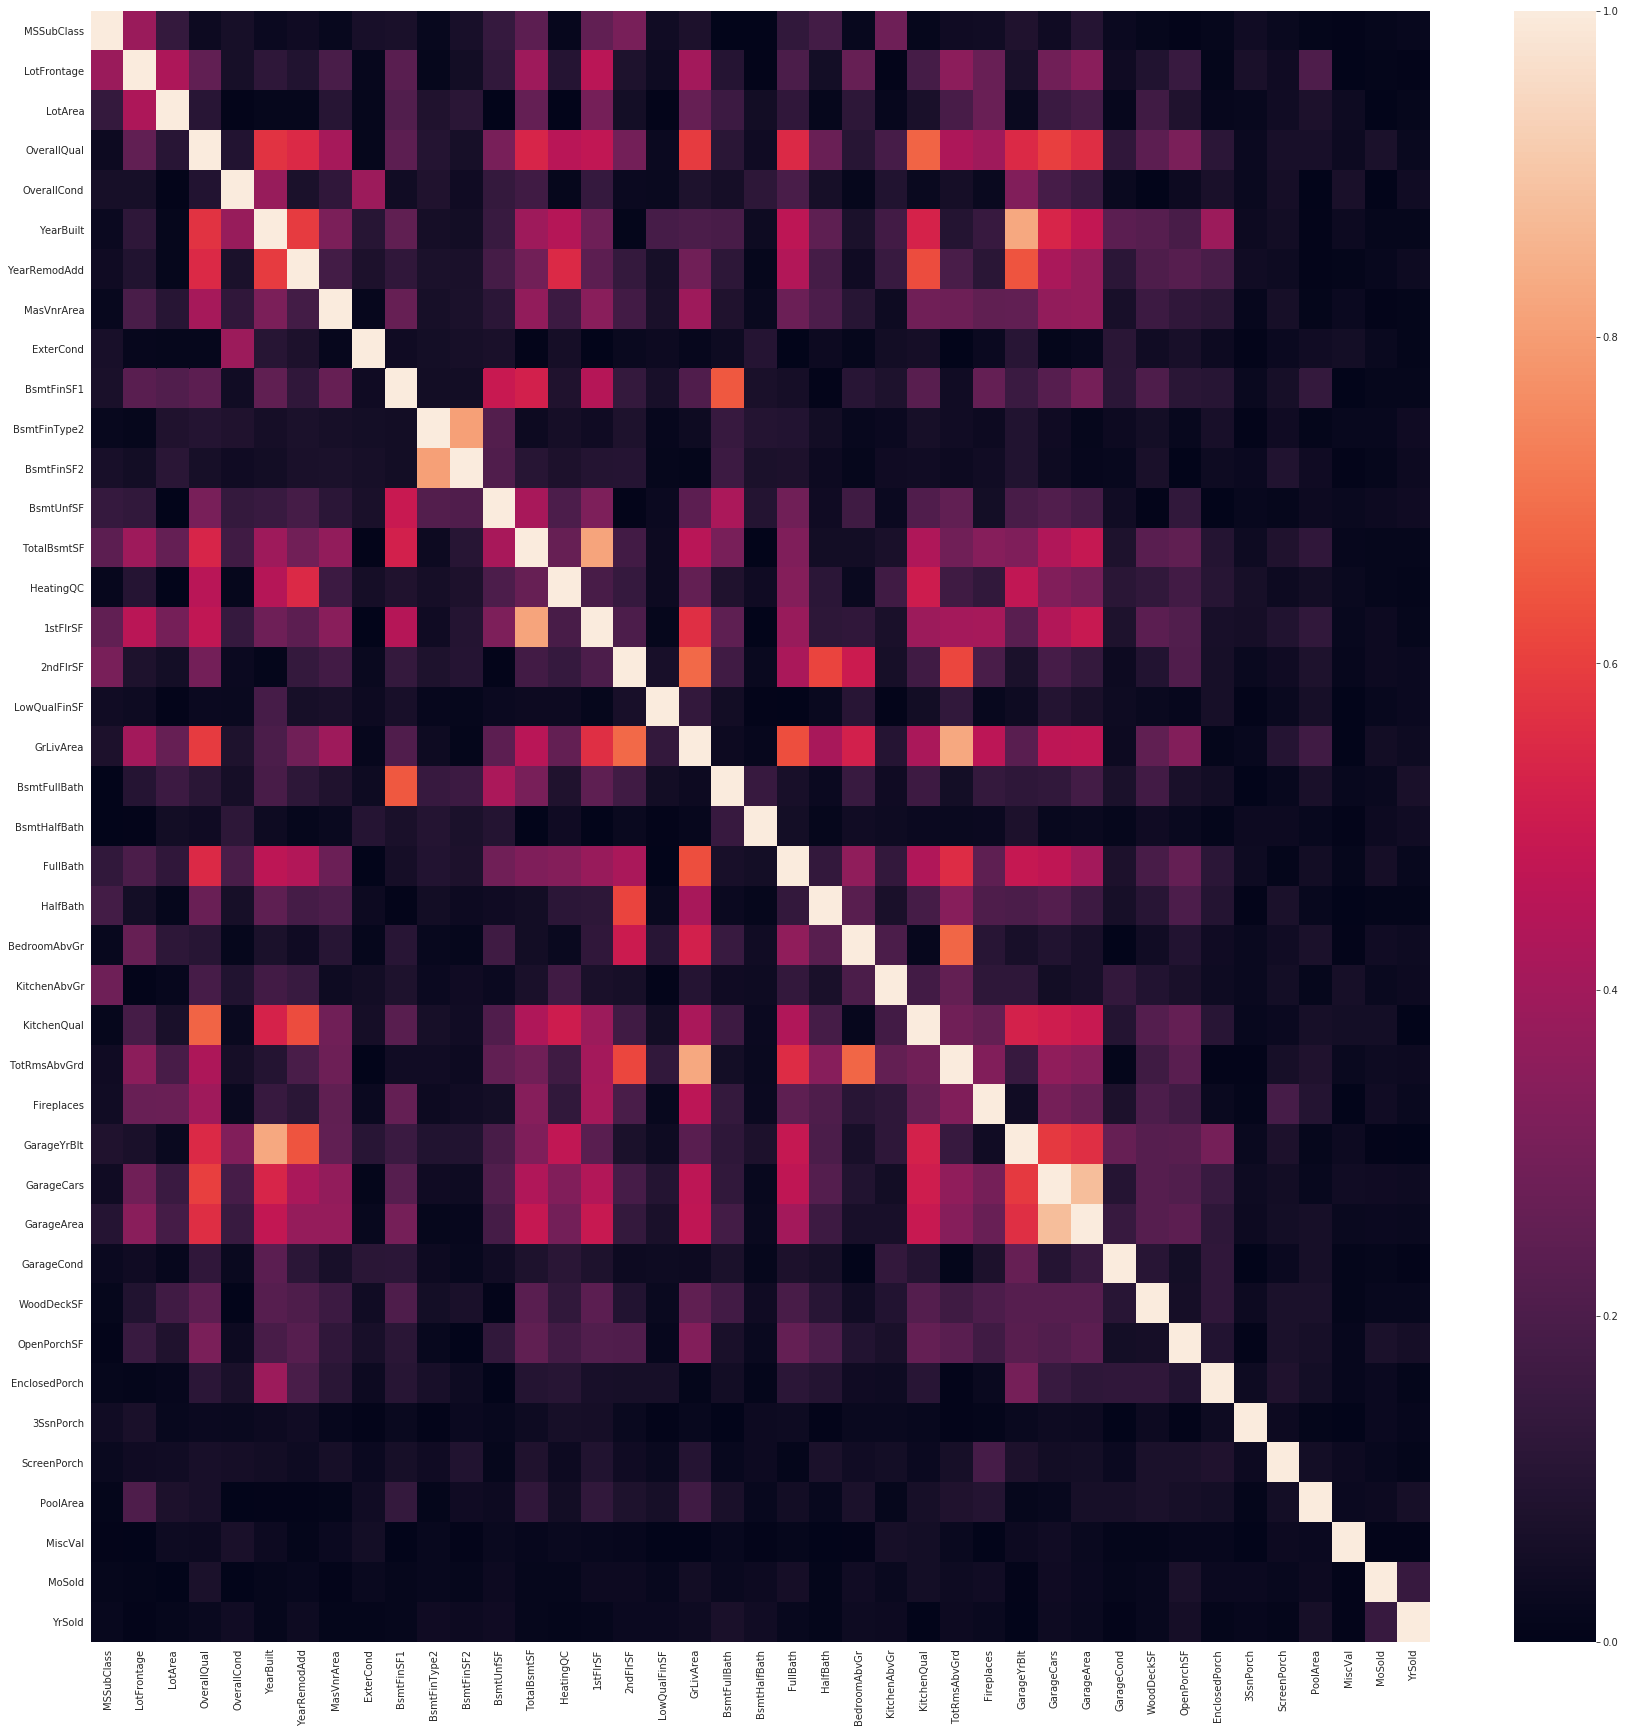

In [73]:
# plot the heatmap with seaborn
plt.figure(figsize=(30,30)) 
sns.heatmap(corr_mat, 
        xticklabels=corr_mat.columns,
        yticklabels=corr_mat.columns)

In [74]:
# display correlation values
#corr_mat.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [75]:
#list the highly correlated columns
corr_tmp = corr_mat.unstack()
corr_tmp = corr_tmp.sort_values(kind="quicksort")

print(corr_tmp[-len(corr_mat)-20:-len(corr_mat)])

YearRemodAdd  GarageYrBlt     0.642277
GarageYrBlt   YearRemodAdd    0.642277
BsmtFullBath  BsmtFinSF1      0.649212
BsmtFinSF1    BsmtFullBath    0.649212
KitchenQual   OverallQual     0.673331
OverallQual   KitchenQual     0.673331
BedroomAbvGr  TotRmsAbvGrd    0.676620
TotRmsAbvGrd  BedroomAbvGr    0.676620
2ndFlrSF      GrLivArea       0.687501
GrLivArea     2ndFlrSF        0.687501
BsmtFinSF2    BsmtFinType2    0.805212
BsmtFinType2  BsmtFinSF2      0.805212
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
GarageYrBlt   YearBuilt       0.825667
YearBuilt     GarageYrBlt     0.825667
GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
dtype: float64


In [76]:
# remove highly correlated columns if needed
if clean_args['rm_cor']:
    columns_corr = ["GarageYrBlt", "GarageCars", "GrLivArea"]
    df_train = df_train.drop(columns=columns_corr)
    df_test = df_test.drop(columns=columns_corr)

In [77]:
# plot all categorical
categorical_list = []

for col in df_train.columns.tolist():
    if df_train[col].dtype == 'object':
        categorical_list.append(col)
        #sns.countplot(col, data=df_train)
        #plt.xticks(rotation=55)
        #plt.show()

In [78]:
print(categorical_list)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'PavedDrive', 'SaleType', 'SaleCondition']


In [79]:
# select categorical list
sel_cat_list = ["MSZoning", "LotConfig", "Neighborhood", "BldgType", "HouseStyle", "Exterior1st", "MasVnrType",
                    "Foundation", "BsmtFinType1", "SaleCondition"]

df_train = pd.get_dummies(df_train, columns=categorical_list)
df_test = pd.get_dummies(df_test, columns=categorical_list)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 251 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(5), int64(37), uint8(209)
memory usage: 788.5 KB


In [80]:
# delete the other categorical columns
for col in df_train.columns.tolist():
    if df_train[col].dtype == 'object':
        del df_train[col]
        del df_test[col]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 251 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(5), int64(37), uint8(209)
memory usage: 788.5 KB


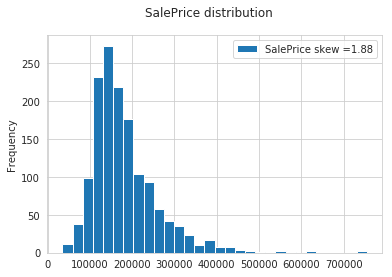

In [84]:
skewness = df_train['SalePrice'].skew()
df_train['SalePrice'].plot.hist(edgecolor='white', bins=30, 
                                label='SalePrice skew =' + str(round(skewness,2)))
plt.suptitle("SalePrice distribution")
plt.legend()
plt.show()

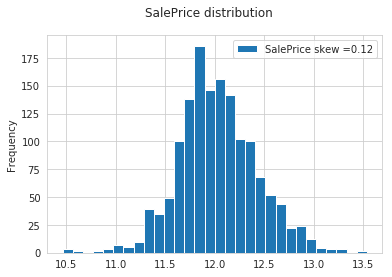

In [85]:
skewness = np.log(df_train['SalePrice']).skew()
np.log(df_train['SalePrice']).plot.hist(edgecolor='white', bins=30, 
                                label='SalePrice skew =' + str(round(skewness,2)))
plt.suptitle("SalePrice distribution")
plt.legend()
plt.show()

del skewness

In [26]:
train_stats = df_train.describe()
train_stats

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,3.083562,443.639726,...,0.003425,0.083562,0.002055,0.867808,0.069178,0.002740,0.008219,0.013699,0.820548,0.085616
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,0.351054,456.098091,...,0.058440,0.276824,0.045299,0.338815,0.253844,0.052289,0.090317,0.116277,0.383862,0.279893
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,3.000000,383.500000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,3.000000,712.250000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5.000000,5644.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
train_dataset = df_train.sample(frac=0.8,random_state=42)
test_dataset = df_train.drop(train_dataset.index)

train_labels = train_dataset.pop('SalePrice')
test_labels = test_dataset.pop('SalePrice')

In [28]:
#whole training dataset to help with normalization
df_train_tmp = df_train.drop(columns=["SalePrice"])

In [29]:
# normalize data
def norm(x):
    #return (x - train_stats['mean']) / train_stats['std']
    return (x - df_train_tmp.mean()) / (df_train_tmp.max() - df_train_tmp.min())

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
norm_sub = norm(df_test)

In [70]:
def model_eval():
    model = XGBRegressor(max_depth=3,
                         learning_rate=0.01,
                         n_estimators=4000,
                         verbosity = 3,
                         objective='reg:linear',
                         n_jobs=-1,
                         min_child_weight=2,
                         subsample=0.7,
                         colsample_bytree=0.65,
                         approx='gpu_hist',
                         random_state=42)
    return model

In [62]:
n_estimators = range(3500, 5001, 250)
max_depth = [2, 3, 4]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
print("number of combinations: {}".format(len(n_estimators)*len(max_depth)))

number of combinations: 21


In [63]:
model = model_eval()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)
grid_result = grid_search.fit(normed_train_data, train_labels)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  9.0min finished


In [64]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.015884 using {'max_depth': 3, 'n_estimators': 4000}
-0.016186 (0.002744) with: {'max_depth': 2, 'n_estimators': 3500}
-0.016153 (0.002688) with: {'max_depth': 2, 'n_estimators': 3750}
-0.016115 (0.002637) with: {'max_depth': 2, 'n_estimators': 4000}
-0.016085 (0.002571) with: {'max_depth': 2, 'n_estimators': 4250}
-0.016075 (0.002530) with: {'max_depth': 2, 'n_estimators': 4500}
-0.016067 (0.002495) with: {'max_depth': 2, 'n_estimators': 4750}
-0.016066 (0.002457) with: {'max_depth': 2, 'n_estimators': 5000}
-0.015901 (0.002978) with: {'max_depth': 3, 'n_estimators': 3500}
-0.015886 (0.002911) with: {'max_depth': 3, 'n_estimators': 3750}
-0.015884 (0.002881) with: {'max_depth': 3, 'n_estimators': 4000}
-0.015908 (0.002856) with: {'max_depth': 3, 'n_estimators': 4250}
-0.015908 (0.002832) with: {'max_depth': 3, 'n_estimators': 4500}
-0.015914 (0.002800) with: {'max_depth': 3, 'n_estimators': 4750}
-0.015930 (0.002791) with: {'max_depth': 3, 'n_estimators': 5000}
-0.016103 (0.00

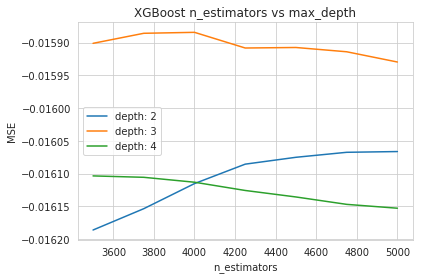

In [65]:
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.title("XGBoost n_estimators vs max_depth")
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.savefig('n_estimators_vs_max_depth.png')

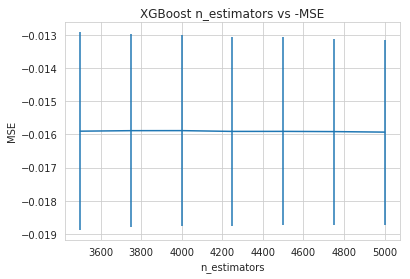

In [66]:
scores_1 = np.array(means).reshape(len(max_depth), len(n_estimators))
scores_2 = np.array(stds).reshape(len(max_depth), len(n_estimators))

plt.errorbar(n_estimators, scores_1[1], yerr=scores_2[1])
plt.title("XGBoost n_estimators vs -MSE")
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.savefig('n_estimators_vs_mse_{}.png'.format(max_depth[1]))

In [67]:
n_estimators = range(3750, 4251, 250)
max_depth = [3]
min_child_weight = range(0, 4, 1)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_child_weight=min_child_weight)
print("number of combinations: {}".format(len(n_estimators)*len(max_depth)*len(min_child_weight)))

number of combinations: 12


In [68]:
model = model_eval()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)
grid_result = grid_search.fit(normed_train_data, train_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.4min finished


In [69]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.015818 using {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 4000}
-0.015886 (0.002911) with: {'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 3750}
-0.015884 (0.002881) with: {'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 4000}
-0.015908 (0.002856) with: {'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 4250}
-0.015886 (0.002911) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 3750}
-0.015884 (0.002881) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 4000}
-0.015908 (0.002856) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 4250}
-0.015840 (0.002316) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 3750}
-0.015818 (0.002279) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 4000}
-0.015823 (0.002260) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 4250}
-0.016046 (0.002304) with: {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 3750}
-0.016041 (0.002254) with:

In [74]:
gamma = np.arange(0.0000, 0.00001, 0.00002)
reg_alpha = np.arange(0.00004, 0.00005, 0.00002)
reg_lambda= np.arange(0.99984, 0.9999, 0.00002)

param_grid = dict(gamma = gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda)
print("number of combinations: {}".format(len(gamma)*len(reg_alpha)*len(reg_lambda)))

number of combinations: 4


In [75]:
model = model_eval()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)
grid_result = grid_search.fit(normed_train_data, train_labels)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:   54.2s remaining:   36.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min finished


In [76]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.015859 using {'gamma': 0.0, 'reg_alpha': 4e-05, 'reg_lambda': 0.99988}
-0.015868 (0.002255) with: {'gamma': 0.0, 'reg_alpha': 4e-05, 'reg_lambda': 0.99984}
-0.015866 (0.002263) with: {'gamma': 0.0, 'reg_alpha': 4e-05, 'reg_lambda': 0.99986}
-0.015859 (0.002264) with: {'gamma': 0.0, 'reg_alpha': 4e-05, 'reg_lambda': 0.99988}
-0.015868 (0.002252) with: {'gamma': 0.0, 'reg_alpha': 4e-05, 'reg_lambda': 0.9999}


In [50]:
model = XGBRegressor(max_depth=3,
                     learning_rate=0.01,
                     n_estimators=4000, #3460
                     verbosity = 3,
                     objective='reg:linear',
                     n_jobs=-1,
                     gamma=0, #dflt: 0
                     min_child_weight=2, #dflt: 0
                     subsample=0.7,
                     colsample_bytree=0.5,
                     reg_lambda=0.99986, #1 dflt: 1
                     reg_alpha=0.00004, #0.00006 dflt: 0
                     tree_method='gpu_hist',
                     scale_pos_weight=1, # dflt: 1
                     random_state=42)

In [51]:
tick=time.time()

fitted_model = model.fit(
    normed_train_data, train_labels,
    eval_set=[(normed_test_data, test_labels)],
    eval_metric='rmse',
    early_stopping_rounds=100,
    verbose=True)

print("Duration: {}s".format(time.time()-tick))

[0]	validation_0-rmse:11.423
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:11.3091
[2]	validation_0-rmse:11.1962
[3]	validation_0-rmse:11.0846
[4]	validation_0-rmse:10.9741
[5]	validation_0-rmse:10.8647
[6]	validation_0-rmse:10.7564
[7]	validation_0-rmse:10.6492
[8]	validation_0-rmse:10.5429
[9]	validation_0-rmse:10.4376
[10]	validation_0-rmse:10.3336
[11]	validation_0-rmse:10.2305
[12]	validation_0-rmse:10.1286
[13]	validation_0-rmse:10.0277
[14]	validation_0-rmse:9.92781
[15]	validation_0-rmse:9.82873
[16]	validation_0-rmse:9.73079
[17]	validation_0-rmse:9.63386
[18]	validation_0-rmse:9.53783
[19]	validation_0-rmse:9.44271
[20]	validation_0-rmse:9.34855
[21]	validation_0-rmse:9.25558
[22]	validation_0-rmse:9.16356
[23]	validation_0-rmse:9.07234
[24]	validation_0-rmse:8.98201
[25]	validation_0-rmse:8.89256
[26]	validation_0-rmse:8.80387
[27]	validation_0-rmse:8.71618
[28]	validation_0-rmse:8.62926
[29]	validation_0-rmse:8.54324
[30]	validation

[258]	validation_0-rmse:0.885129
[259]	validation_0-rmse:0.876548
[260]	validation_0-rmse:0.868151
[261]	validation_0-rmse:0.859862
[262]	validation_0-rmse:0.851669
[263]	validation_0-rmse:0.843514
[264]	validation_0-rmse:0.835471
[265]	validation_0-rmse:0.827411
[266]	validation_0-rmse:0.819593
[267]	validation_0-rmse:0.811804
[268]	validation_0-rmse:0.80402
[269]	validation_0-rmse:0.796259
[270]	validation_0-rmse:0.788662
[271]	validation_0-rmse:0.78124
[272]	validation_0-rmse:0.773964
[273]	validation_0-rmse:0.766638
[274]	validation_0-rmse:0.759445
[275]	validation_0-rmse:0.752141
[276]	validation_0-rmse:0.74505
[277]	validation_0-rmse:0.738015
[278]	validation_0-rmse:0.731041
[279]	validation_0-rmse:0.724131
[280]	validation_0-rmse:0.717337
[281]	validation_0-rmse:0.710451
[282]	validation_0-rmse:0.703799
[283]	validation_0-rmse:0.697176
[284]	validation_0-rmse:0.690543
[285]	validation_0-rmse:0.684019
[286]	validation_0-rmse:0.677576
[287]	validation_0-rmse:0.67124
[288]	validati

[508]	validation_0-rmse:0.146589
[509]	validation_0-rmse:0.146134
[510]	validation_0-rmse:0.145665
[511]	validation_0-rmse:0.145257
[512]	validation_0-rmse:0.144774
[513]	validation_0-rmse:0.144313
[514]	validation_0-rmse:0.143879
[515]	validation_0-rmse:0.143408
[516]	validation_0-rmse:0.14299
[517]	validation_0-rmse:0.142645
[518]	validation_0-rmse:0.142261
[519]	validation_0-rmse:0.141862
[520]	validation_0-rmse:0.141486
[521]	validation_0-rmse:0.141129
[522]	validation_0-rmse:0.140706
[523]	validation_0-rmse:0.140342
[524]	validation_0-rmse:0.139998
[525]	validation_0-rmse:0.13968
[526]	validation_0-rmse:0.139343
[527]	validation_0-rmse:0.139003
[528]	validation_0-rmse:0.138708
[529]	validation_0-rmse:0.138402
[530]	validation_0-rmse:0.138089
[531]	validation_0-rmse:0.137779
[532]	validation_0-rmse:0.137471
[533]	validation_0-rmse:0.137213
[534]	validation_0-rmse:0.136904
[535]	validation_0-rmse:0.136538
[536]	validation_0-rmse:0.136281
[537]	validation_0-rmse:0.135983
[538]	valida

[757]	validation_0-rmse:0.114544
[758]	validation_0-rmse:0.114518
[759]	validation_0-rmse:0.1145
[760]	validation_0-rmse:0.114444
[761]	validation_0-rmse:0.11439
[762]	validation_0-rmse:0.114353
[763]	validation_0-rmse:0.114307
[764]	validation_0-rmse:0.114297
[765]	validation_0-rmse:0.114238
[766]	validation_0-rmse:0.114222
[767]	validation_0-rmse:0.114192
[768]	validation_0-rmse:0.114138
[769]	validation_0-rmse:0.11412
[770]	validation_0-rmse:0.114072
[771]	validation_0-rmse:0.114018
[772]	validation_0-rmse:0.113991
[773]	validation_0-rmse:0.113978
[774]	validation_0-rmse:0.113958
[775]	validation_0-rmse:0.113884
[776]	validation_0-rmse:0.113849
[777]	validation_0-rmse:0.113843
[778]	validation_0-rmse:0.113807
[779]	validation_0-rmse:0.113794
[780]	validation_0-rmse:0.113777
[781]	validation_0-rmse:0.113749
[782]	validation_0-rmse:0.113716
[783]	validation_0-rmse:0.11367
[784]	validation_0-rmse:0.113618
[785]	validation_0-rmse:0.113592
[786]	validation_0-rmse:0.113558
[787]	validatio

[1006]	validation_0-rmse:0.110645
[1007]	validation_0-rmse:0.110638
[1008]	validation_0-rmse:0.110613
[1009]	validation_0-rmse:0.110589
[1010]	validation_0-rmse:0.1106
[1011]	validation_0-rmse:0.110602
[1012]	validation_0-rmse:0.110615
[1013]	validation_0-rmse:0.110624
[1014]	validation_0-rmse:0.110606
[1015]	validation_0-rmse:0.110598
[1016]	validation_0-rmse:0.110585
[1017]	validation_0-rmse:0.110581
[1018]	validation_0-rmse:0.110571
[1019]	validation_0-rmse:0.110614
[1020]	validation_0-rmse:0.110606
[1021]	validation_0-rmse:0.110559
[1022]	validation_0-rmse:0.110549
[1023]	validation_0-rmse:0.110533
[1024]	validation_0-rmse:0.110491
[1025]	validation_0-rmse:0.11046
[1026]	validation_0-rmse:0.110446
[1027]	validation_0-rmse:0.110454
[1028]	validation_0-rmse:0.11046
[1029]	validation_0-rmse:0.110446
[1030]	validation_0-rmse:0.110459
[1031]	validation_0-rmse:0.110457
[1032]	validation_0-rmse:0.110462
[1033]	validation_0-rmse:0.110455
[1034]	validation_0-rmse:0.110436
[1035]	validation_

[1248]	validation_0-rmse:0.10898
[1249]	validation_0-rmse:0.108982
[1250]	validation_0-rmse:0.108996
[1251]	validation_0-rmse:0.108996
[1252]	validation_0-rmse:0.108981
[1253]	validation_0-rmse:0.108986
[1254]	validation_0-rmse:0.108982
[1255]	validation_0-rmse:0.108984
[1256]	validation_0-rmse:0.108984
[1257]	validation_0-rmse:0.108978
[1258]	validation_0-rmse:0.108987
[1259]	validation_0-rmse:0.108975
[1260]	validation_0-rmse:0.108981
[1261]	validation_0-rmse:0.108966
[1262]	validation_0-rmse:0.10896
[1263]	validation_0-rmse:0.10896
[1264]	validation_0-rmse:0.108936
[1265]	validation_0-rmse:0.108955
[1266]	validation_0-rmse:0.10894
[1267]	validation_0-rmse:0.108936
[1268]	validation_0-rmse:0.10892
[1269]	validation_0-rmse:0.108924
[1270]	validation_0-rmse:0.108925
[1271]	validation_0-rmse:0.108904
[1272]	validation_0-rmse:0.108899
[1273]	validation_0-rmse:0.108926
[1274]	validation_0-rmse:0.108915
[1275]	validation_0-rmse:0.108902
[1276]	validation_0-rmse:0.108899
[1277]	validation_0

[1490]	validation_0-rmse:0.107817
[1491]	validation_0-rmse:0.107784
[1492]	validation_0-rmse:0.107773
[1493]	validation_0-rmse:0.107774
[1494]	validation_0-rmse:0.107786
[1495]	validation_0-rmse:0.107786
[1496]	validation_0-rmse:0.107811
[1497]	validation_0-rmse:0.107786
[1498]	validation_0-rmse:0.107783
[1499]	validation_0-rmse:0.107764
[1500]	validation_0-rmse:0.107775
[1501]	validation_0-rmse:0.107762
[1502]	validation_0-rmse:0.107762
[1503]	validation_0-rmse:0.10776
[1504]	validation_0-rmse:0.107767
[1505]	validation_0-rmse:0.107758
[1506]	validation_0-rmse:0.107767
[1507]	validation_0-rmse:0.107764
[1508]	validation_0-rmse:0.107732
[1509]	validation_0-rmse:0.107718
[1510]	validation_0-rmse:0.107713
[1511]	validation_0-rmse:0.107709
[1512]	validation_0-rmse:0.107702
[1513]	validation_0-rmse:0.107714
[1514]	validation_0-rmse:0.10771
[1515]	validation_0-rmse:0.107715
[1516]	validation_0-rmse:0.107712
[1517]	validation_0-rmse:0.107696
[1518]	validation_0-rmse:0.107691
[1519]	validatio

[1732]	validation_0-rmse:0.106913
[1733]	validation_0-rmse:0.106925
[1734]	validation_0-rmse:0.106933
[1735]	validation_0-rmse:0.106939
[1736]	validation_0-rmse:0.106915
[1737]	validation_0-rmse:0.106908
[1738]	validation_0-rmse:0.106896
[1739]	validation_0-rmse:0.106879
[1740]	validation_0-rmse:0.106853
[1741]	validation_0-rmse:0.106853
[1742]	validation_0-rmse:0.106861
[1743]	validation_0-rmse:0.106848
[1744]	validation_0-rmse:0.106849
[1745]	validation_0-rmse:0.106864
[1746]	validation_0-rmse:0.106861
[1747]	validation_0-rmse:0.106852
[1748]	validation_0-rmse:0.106846
[1749]	validation_0-rmse:0.106827
[1750]	validation_0-rmse:0.106818
[1751]	validation_0-rmse:0.106808
[1752]	validation_0-rmse:0.106813
[1753]	validation_0-rmse:0.106811
[1754]	validation_0-rmse:0.106794
[1755]	validation_0-rmse:0.106792
[1756]	validation_0-rmse:0.106799
[1757]	validation_0-rmse:0.106812
[1758]	validation_0-rmse:0.106803
[1759]	validation_0-rmse:0.106805
[1760]	validation_0-rmse:0.106789
[1761]	validat

[1974]	validation_0-rmse:0.106277
[1975]	validation_0-rmse:0.106278
[1976]	validation_0-rmse:0.106272
[1977]	validation_0-rmse:0.106275
[1978]	validation_0-rmse:0.106269
[1979]	validation_0-rmse:0.106264
[1980]	validation_0-rmse:0.106265
[1981]	validation_0-rmse:0.106261
[1982]	validation_0-rmse:0.106232
[1983]	validation_0-rmse:0.106214
[1984]	validation_0-rmse:0.106214
[1985]	validation_0-rmse:0.106222
[1986]	validation_0-rmse:0.106219
[1987]	validation_0-rmse:0.106207
[1988]	validation_0-rmse:0.106216
[1989]	validation_0-rmse:0.106198
[1990]	validation_0-rmse:0.106203
[1991]	validation_0-rmse:0.106209
[1992]	validation_0-rmse:0.106184
[1993]	validation_0-rmse:0.10619
[1994]	validation_0-rmse:0.106195
[1995]	validation_0-rmse:0.106179
[1996]	validation_0-rmse:0.106188
[1997]	validation_0-rmse:0.106179
[1998]	validation_0-rmse:0.106164
[1999]	validation_0-rmse:0.106177
[2000]	validation_0-rmse:0.106161
[2001]	validation_0-rmse:0.106149
[2002]	validation_0-rmse:0.106149
[2003]	validati

[2216]	validation_0-rmse:0.105743
[2217]	validation_0-rmse:0.105723
[2218]	validation_0-rmse:0.105721
[2219]	validation_0-rmse:0.105713
[2220]	validation_0-rmse:0.105715
[2221]	validation_0-rmse:0.105709
[2222]	validation_0-rmse:0.105713
[2223]	validation_0-rmse:0.105709
[2224]	validation_0-rmse:0.105728
[2225]	validation_0-rmse:0.105705
[2226]	validation_0-rmse:0.105712
[2227]	validation_0-rmse:0.105706
[2228]	validation_0-rmse:0.105707
[2229]	validation_0-rmse:0.105699
[2230]	validation_0-rmse:0.105702
[2231]	validation_0-rmse:0.105695
[2232]	validation_0-rmse:0.105683
[2233]	validation_0-rmse:0.105692
[2234]	validation_0-rmse:0.105693
[2235]	validation_0-rmse:0.105708
[2236]	validation_0-rmse:0.105707
[2237]	validation_0-rmse:0.105713
[2238]	validation_0-rmse:0.105725
[2239]	validation_0-rmse:0.105721
[2240]	validation_0-rmse:0.105721
[2241]	validation_0-rmse:0.105717
[2242]	validation_0-rmse:0.105709
[2243]	validation_0-rmse:0.105702
[2244]	validation_0-rmse:0.105691
[2245]	validat

[2458]	validation_0-rmse:0.105509
[2459]	validation_0-rmse:0.105505
[2460]	validation_0-rmse:0.105523
[2461]	validation_0-rmse:0.105514
[2462]	validation_0-rmse:0.105518
[2463]	validation_0-rmse:0.10551
[2464]	validation_0-rmse:0.10551
[2465]	validation_0-rmse:0.105484
[2466]	validation_0-rmse:0.105477
[2467]	validation_0-rmse:0.10546
[2468]	validation_0-rmse:0.105457
[2469]	validation_0-rmse:0.105459
[2470]	validation_0-rmse:0.105456
[2471]	validation_0-rmse:0.105448
[2472]	validation_0-rmse:0.105452
[2473]	validation_0-rmse:0.105457
[2474]	validation_0-rmse:0.105457
[2475]	validation_0-rmse:0.105458
[2476]	validation_0-rmse:0.105446
[2477]	validation_0-rmse:0.105458
[2478]	validation_0-rmse:0.105451
[2479]	validation_0-rmse:0.105454
[2480]	validation_0-rmse:0.105455
[2481]	validation_0-rmse:0.105457
[2482]	validation_0-rmse:0.105456
[2483]	validation_0-rmse:0.105463
[2484]	validation_0-rmse:0.105451
[2485]	validation_0-rmse:0.105449
[2486]	validation_0-rmse:0.105446
[2487]	validation

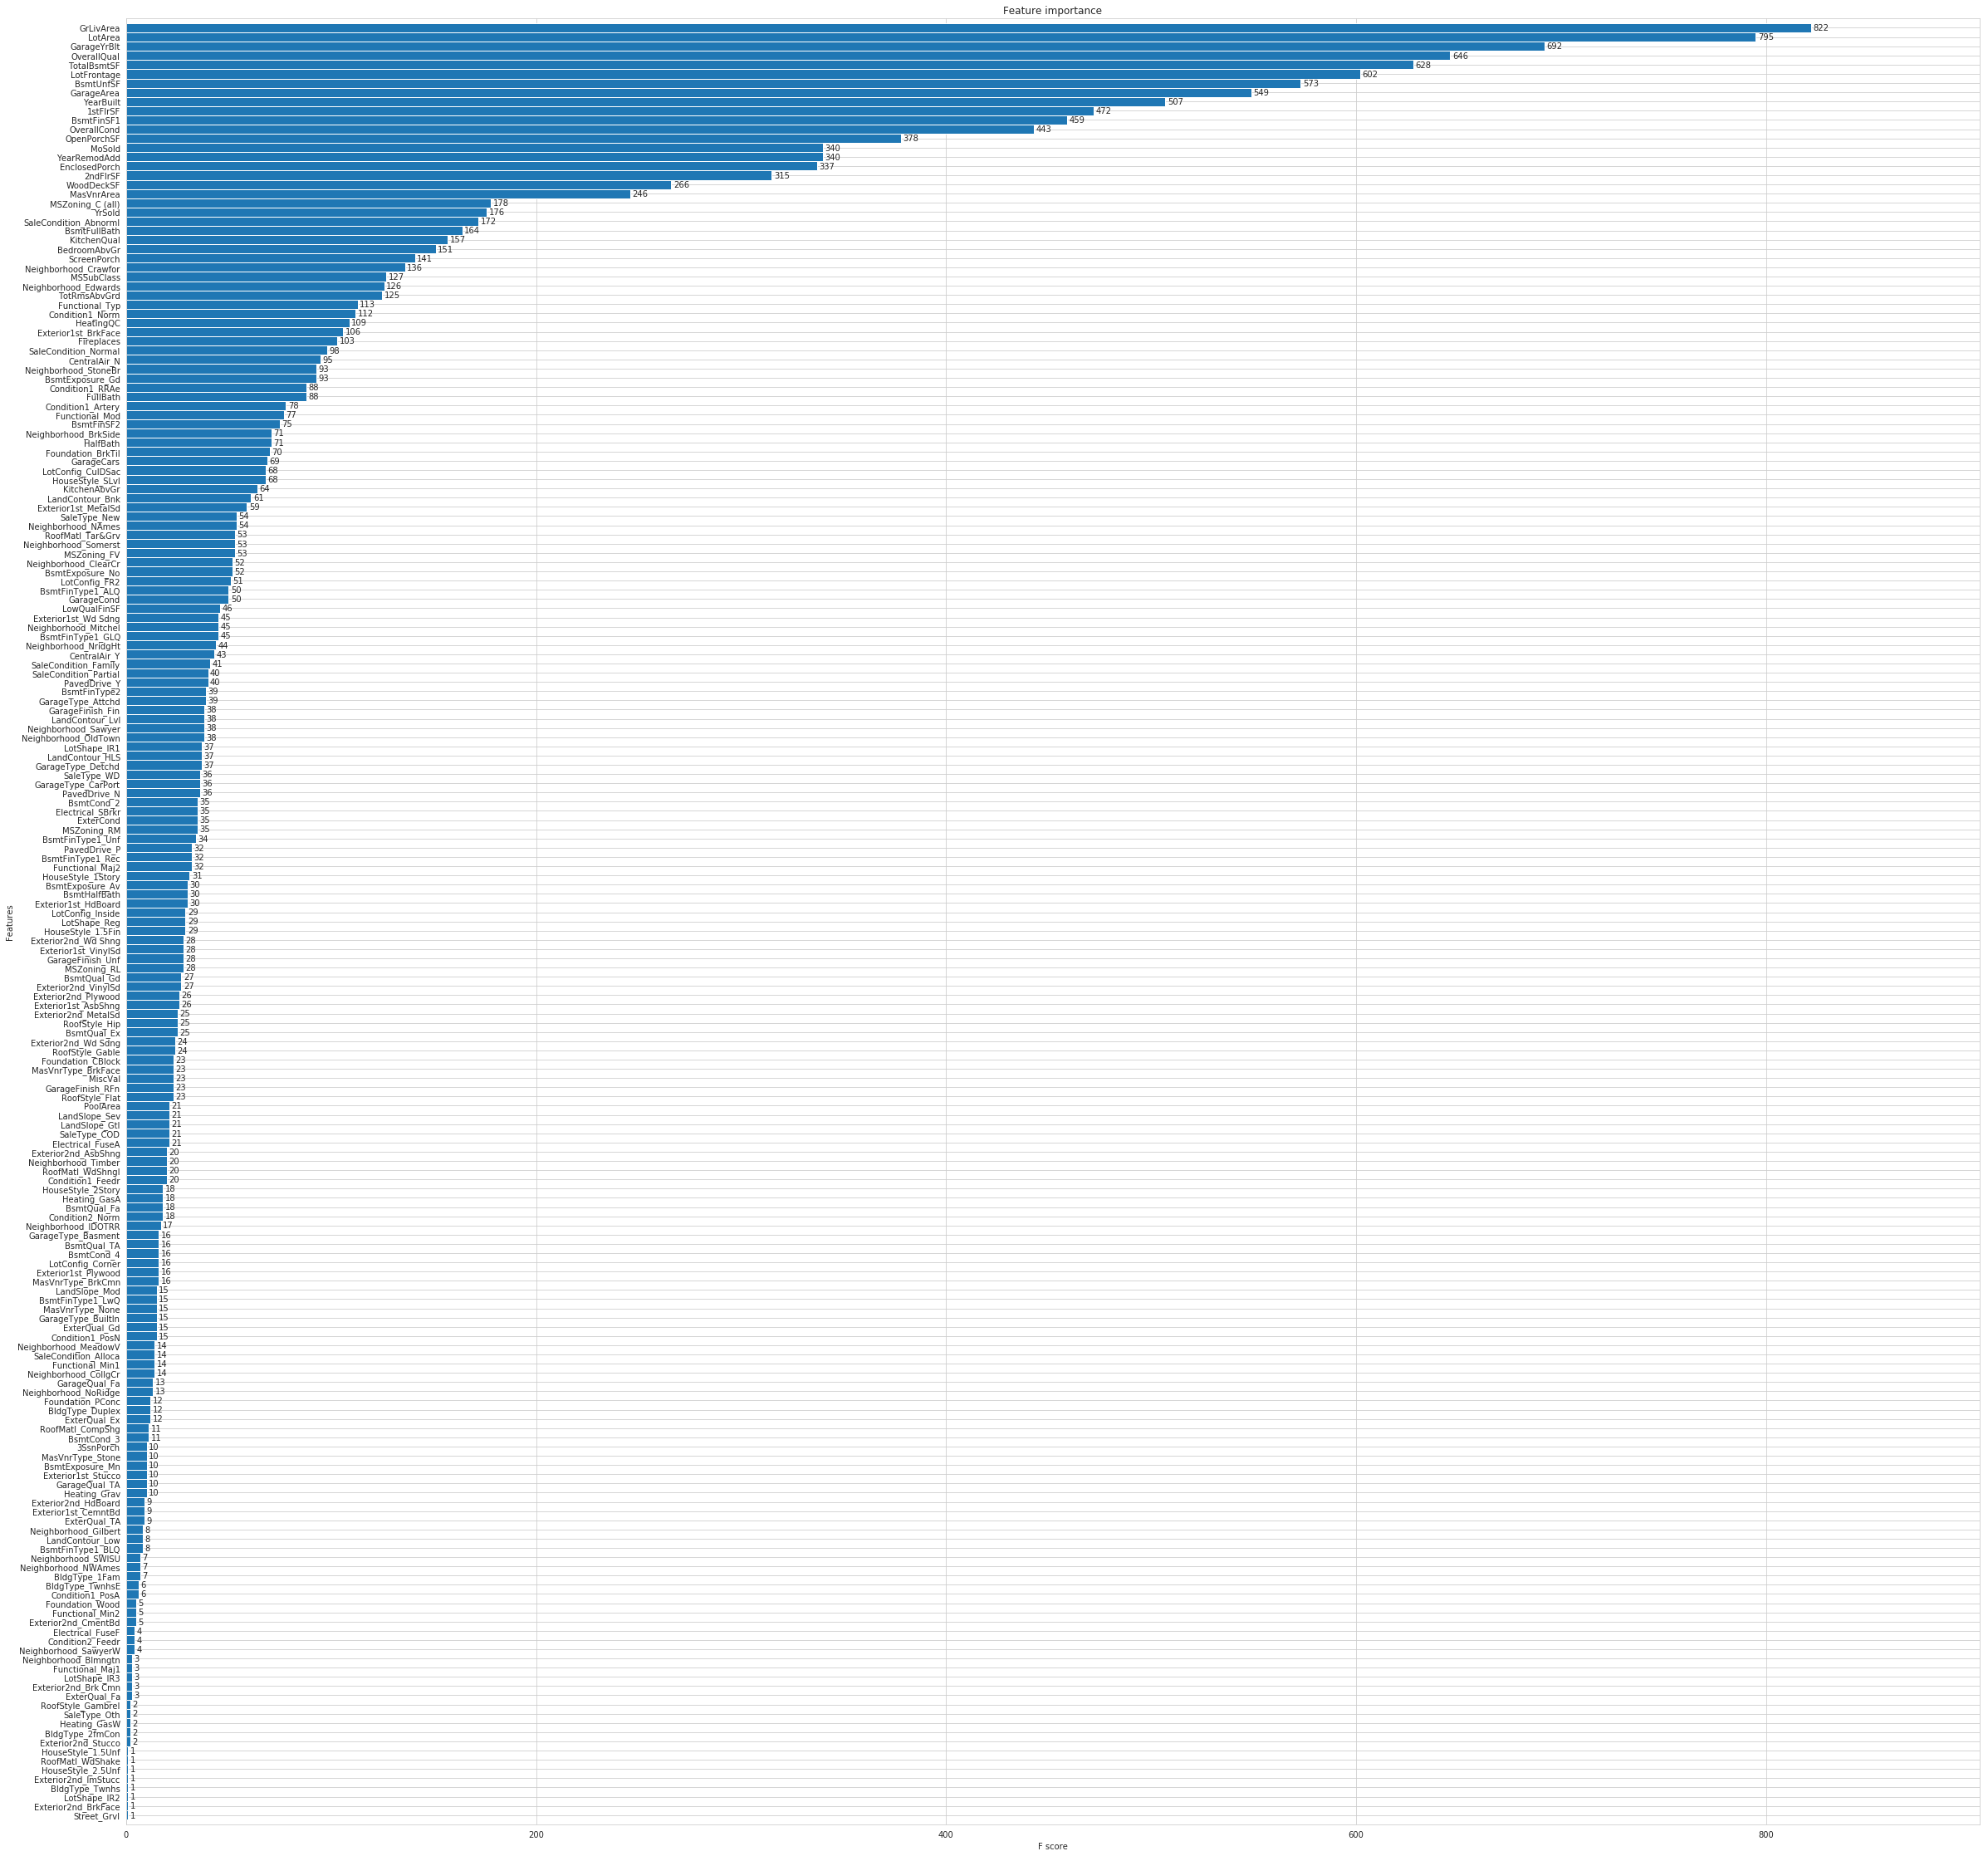

In [52]:
figsize=(40,40)
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_importance(model, ax=ax,height = 1)

In [53]:
predictions = model.predict(norm_sub[normed_test_data.columns])
predictions = np.floor(np.exp(predictions))

In [54]:
predictions

array([124288., 163161., 186873., ..., 168141., 115315., 219939.],
      dtype=float32)

In [55]:
my_submission = pd.DataFrame({'Id': df_test.index, 'SalePrice': predictions})
my_submission.to_csv('submission.csv', index=False)

In [56]:
my_submission.head()

,Id,SalePrice
0,1461,124288.0
1,1462,163161.0
2,1463,186873.0
3,1464,194277.0
4,1465,180086.0


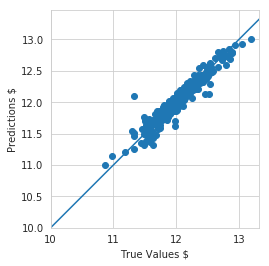

In [91]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values $')
plt.ylabel('Predictions $')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,plt.xlim()[1]])
plt.ylim([10,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


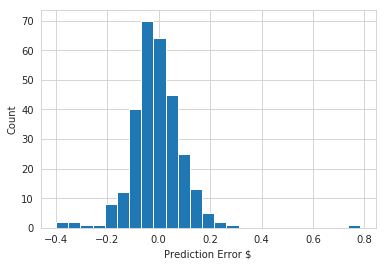

In [58]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error $")
_ = plt.ylabel("Count")

In [ ]:
results = cross_val_score(model, , cv=kfold)